<div style='width:400px; height:160px; border-bottom:10px black solid;border-left: 10px green solid;padding: 10px 10px 10px 10px;'>
    <h1> ---Timeseries forcasting of the Norwegian salmon exportation---</h1>
    <h3> Author: Jakob Lindstrøm </h3>
    <h3> Date: 29.05.2023 </h3>
</div>

<div style='width:450px; height:380px; padding: 10px 10px 10px 10px;border-bottom:10px black solid;
            border-left: 10px green solid'>
    <div>
        <h4>Keywords:</h4>
        <p> Salmon, timeseries, SARIMAX </p>
        <h4> Data sources:  </h4>
        <p> MET: https://api.met.no/ </p>
        <p> geonorge: https://www.geonorge.no/ </p>
        <h4> Intention: </h4>
        <p> This programe has the goal of predicting and forecasting the norwegian salmon export. This programe will be using a SARIMAX model and using the  Euro_Nok  currency  as a exogenous variable. I will predict the 2019 exportation and compared it against real values, and forecast the exportation for 2020.
    </div>
</div>

<h2> Importation of libraries

In [33]:
#Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#Statistical libraries
import statsmodels as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

#Timeseries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import pmdarima
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

<h2> Creation of the dataframe 

In [2]:
Salmon_ton = pd.read_excel('expsal.xlsx')['Unnamed: 2'][2:523].reset_index()
del Salmon_ton['index']

euro_nok = pd.read_csv('euro.csv')['Adj Close'][:521]

datetime = pd.date_range('2010-01', periods=521, freq='w')

df = pd.DataFrame({'Salmon_ton':Salmon_ton['Unnamed: 2'],'Euro_Nok':euro_nok})
df.set_index(datetime)

,Salmon_ton,Euro_Nok
2010-01-03,11067,0.122200
2010-01-10,10808,0.122320
2010-01-17,10891,0.122060
2010-01-24,10967,0.121430
2010-01-31,10826,0.122000
...,...,...
2019-11-24,21783,0.099093
2019-12-01,20399,0.098462
2019-12-08,22556,0.098579
2019-12-15,20352,0.099785


<h2> Exploratory  data analysis

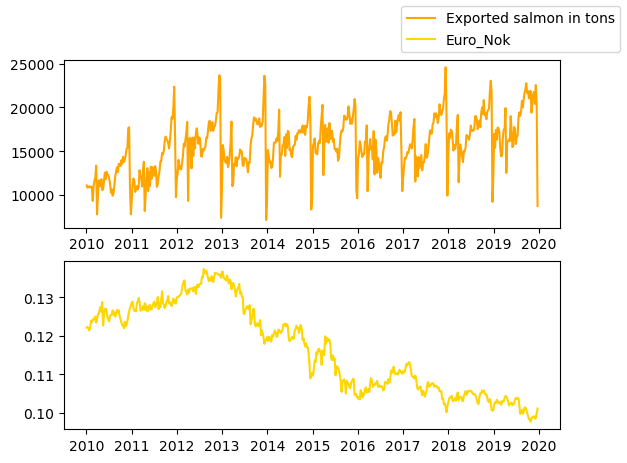

In [3]:
datetime = pd.date_range('2010-01', periods=521, freq='w')
df['Week'] = datetime
df = df.set_index('Week')
df.head()
fig, ax = plt.subplots(2)
ax[0].plot(df['Salmon_ton'], label='Exported salmon in tons', color='orange')
ax[1].plot(df['Euro_Nok'], label='Euro_Nok',color='gold')
fig.legend()
plt.show()

<h2> Checking the  variables with an ADF-test

In [4]:
aggdf = pd.DataFrame()
aggdf['Salmon_ton'] = df['Salmon_ton'].diff().resample('M').sum()
aggdf['Euro_Nok'] = df['Euro_Nok'].diff().resample('M').sum()

print('p-value of adfuller test on differenciated Salmon_ton is:', round(adfuller(aggdf['Salmon_ton'])[1],4))
print('p-value of adfuller test on differenciated Salmon_ton is:', round(adfuller(aggdf['Euro_Nok'])[1],4))

p-value of adfuller test on differenciated Salmon_ton is: 0.0
p-value of adfuller test on differenciated Salmon_ton is: 0.0


<h2> Decompose the main variable

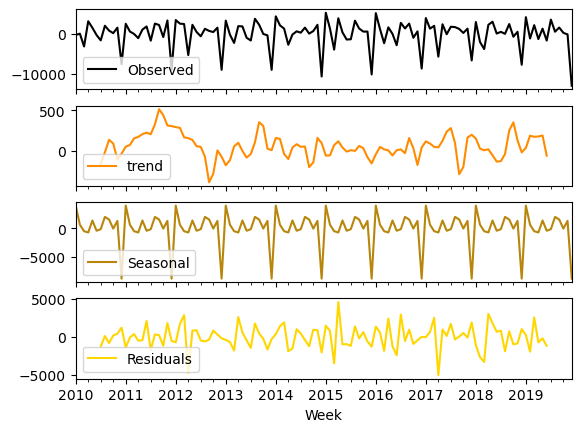

In [5]:
decomposition = sm.tsa.seasonal_decompose(aggdf['Salmon_ton'], model='additive')

fig, ax = plt.subplots(4,1, sharex=True)
decomposition.observed.plot(ax=ax[0], label='Observed', color='black')
ax[0].legend(loc='lower left')
decomposition.trend.plot(ax=ax[1], label='trend', color='darkorange')
ax[1].legend(loc='lower left')
decomposition.seasonal.plot(ax=ax[2], label='Seasonal',color='darkgoldenrod')
ax[2].legend(loc='lower left')
decomposition.resid.plot(ax=ax[3], label='Residuals', color='gold')
ax[3].legend(loc='lower left')
plt.show()

<h2> Finding best values for SARIMA

In [6]:
SARIMA_model = auto_arima(aggdf[['Salmon_ton']],
                          exogenous=aggdf[['Euro_Nok']],
                          test='adf',
                          m=12,
                          seasonal=True,
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  120
Model:             SARIMAX(5, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1071.198
Date:                                 Mon, 29 May 2023   AIC                           2162.396
Time:                                         14:19:30   BIC                           2190.271
Sample:                                     01-31-2010   HQIC                          2173.716
                                          - 12-31-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Euro_Nok     2.42e+05   7.06e+04      3.429      0.001    1.04e+05     3.8e+05
ar.L1         -0.5630      0.116     -4.866      0.000      -0.790      -0.336
ar.L2         -0.5526      0.153     -3.620      0.000      -0.852      -0.253
ar.L3         -0.4161      0.161     -2.590      0.010      -0.731      -0.101
ar.L4         -0.3062      0.152     -2.009      0.045      -0.605      -0.007
ar.L5         -0.2336      0.105     -2.226      0.026      -0.439      -0.028
ar.S.L12       0.9942      0.007    148.809      0.000       0.981       1.007
ma.S.L12      -1.0924      0.120     -9.070      0.000      -1.329      -0.856
ma.S.L24       0.2844      0.141      2.019      0.044       0.008       0.561
sigma2      2.819e+06   2741.449   1028.143      0.000    2.81e+06    2.82e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 9.01
Prob(Q):                              0.76   Prob(JB):                         0.01
Heteroskedasticity (H):               1.10   Skew:                            -0.38
Prob(H) (two-sided):                  0.76   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+18. Standard errors may be unstable.
"""

In [7]:
SARIMA_model

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

<H2> Making the precitions and forecasts

In [25]:
def fcmodel(fc):
    #First I get data for the forecasting
    forecasting = sm.tsa.SARIMAX(endog=aggdf.Salmon_ton.astype('float'),
                                 exog=aggdf.Euro_Nok,
                                 order=(5,0,0),
                                 seasonal_order=(1,0,2,12)).fit()
 
    forecasting = forecasting.get_forecast(exog=fc,
                                        steps=len(fc)).summary_frame()
 
    forecasting['Date'] = pd.date_range(start='1-1-2020',
                                        freq='MS',
                                        periods=12)
 
    #Then I get data for the predictions using train-test-split
    train = aggdf[:108]
    test = aggdf[108:]
    tssmodel = SARIMAX(endog=train['Salmon_ton'].astype('float'),
                        exog=train['Euro_Nok'],
                        order=(5,0,0),
                        seasonal_order=(1,0,2,12)).fit()
    
    tsspredictions = tssmodel.get_prediction(start=108,
                                            end=119,
                                            exog=test['Euro_Nok']).summary_frame() 
    
    tsspredictions['Date'] = pd.date_range(start='1-1-2019',
                                            freq='MS',
                                            periods=12)


    
    return [forecasting,tsspredictions]

<h2> Making forecasts for the exogenous variable

In [34]:
# Forecasting a weak Norwegian Krone
low = fcmodel(np.repeat(-0.001,12))
# Forecasting a stable Norweigan Krone
medium = fcmodel(np.repeat(0,12))
# Forecasting a strong Norwegian Krone
high = fcmodel(np.repeat(0.001,12))
print()

In [29]:
prdevelop = np.cumsum(np.repeat(.001,12))
futpr = 0.101216
prlist = []
for i in range(0,12,1):
 futpr+=prdevelop[i]
 prlist.append(round(futpr,3))
print('The future strong Norwegian Krone in one year is:',round(futpr,4))
print('The currency development in 2020 will look like this:',prlist)

The future strong Norwegian Krone in one year is: 0.1792
The currency development in 2020 will look like this: [0.102, 0.104, 0.107, 0.111, 0.116, 0.122, 0.129, 0.137, 0.146, 0.156, 0.167, 0.179]


<h2>Plotting forecasts and predictions 

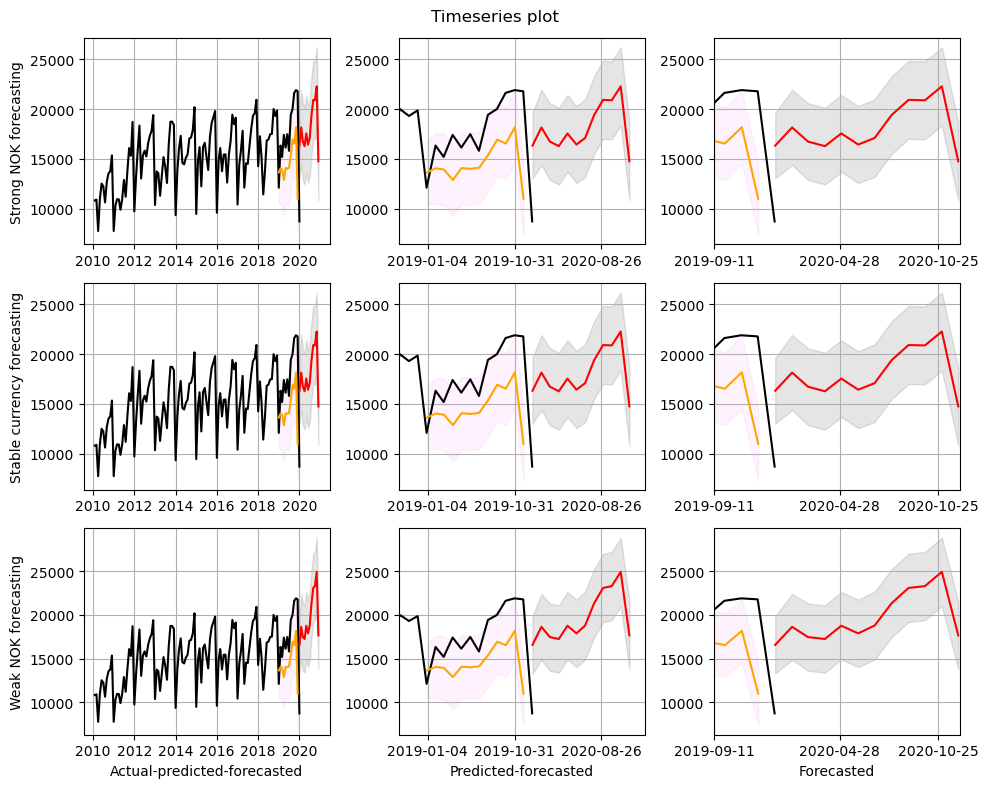

In [32]:
#Creating the plot
def fcmodel_plot(fc_list,pred_list,name_list,what_list):
    fig, ax = plt.subplots(len(fc_list),3, figsize=(10,8))
    for i in range(0,3,1):
        for j in range(0,3,1):
 
            #Actual values
            ax[i,j].plot(11067+np.cumsum(aggdf.Salmon_ton),
                        color='black')
            ax[i,j].grid()
 
            #Train-test-split values
            ax[i,j].plot(pred_list[i]['Date'],
                        9179+np.cumsum(pred_list[i]['mean']),
                        color='orange')
 
            ax[i,j].fill_between(pred_list[i].Date,
                                (9179+np.cumsum(pred_list[i]['mean'])) -
                                ((pred_list[i]['mean']-
                                pred_list[i]['mean_ci_lower'])),
                                (9179+np.cumsum(pred_list[i]['mean'])) +
                                (-(pred_list[i]['mean'] -
                                pred_list[i]['mean_ci_upper'])),
                                color='violet',
                                alpha=.1)
            ax[i,1].set_xticks([17900,18200,18500])
 
            #Forecasted-values
            ax[i,j].plot(fc_list[i]['Date'],
                        8714+np.cumsum(fc_list[i]['mean']),
                        color='red')
            ax[i,j].fill_between(fc_list[i].Date,
                                (8714+np.cumsum(fc_list[i]['mean'])) +
                                (-(fc_list[i]['mean'] -
                                fc_list[i]['mean_ci_upper'])),
                                (8714+np.cumsum(fc_list[i]['mean'])) -
                                ((fc_list[i]['mean']) -
                                (fc_list[i]['mean_ci_lower'])),
                                color='black',
                                alpha=.1)
            ax[i,2].set_xticks([18150,18380,18560])
 
            ax[2,j].set_xlabel(what_list[j])
        ax[i,0].set_ylabel(name_list[i]+' forecasting')
        ax[i,1].set_xlim(17800,18650)
        ax[i,2].set_xlim(18150,18600) 
    fig.suptitle('Timeseries plot')
    fig.tight_layout()
 #Tells what the function shall return
    return plt.show()
#Calling the function
fcmodel_plot([low[0],medium[0],high[0]],
            [low[1],medium[1],high[1]],
            ['Strong NOK','Stable currency','Weak NOK'],
            ['Actual-predicted-forecasted','Predicted-forecasted','Forecasted' ])

<p style=font-family:verdana> The plot above shows the same predictions and real value, however the red line in the rows represent three different scenarios for how the currency will develop over one year.